In [2]:
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv("data/historical_orders.csv")

In [4]:
df

,order_id,city,zone,distance_km,estimated_time_min,order_value,base_delivery_fee,surge_multiplier,weather,rain_intensity,...,day_of_week,is_weekend,festival_flag,restaurant_prep_time,historical_rider_speed,historical_acceptance_rate_zone,historical_cancel_rate_zone,delivery_revenue,incentive_given,order_accepted
0,10001,Delhi,Suburban,2.3,15.7,177.0,30.0,1.59,Cloudy,0.09,...,Saturday,1,0,21.7,21.6,0.746,0.029,86.64,44.0,0
1,10002,Jaipur,East,12.4,37.4,283.0,68.0,1.08,Cloudy,0.06,...,Wednesday,0,0,16.8,15.2,0.881,0.295,135.70,49.0,1
2,10003,Chennai,Airport,13.2,56.9,702.0,76.0,1.23,Clear,0.04,...,Monday,0,0,17.6,18.2,0.830,0.074,247.92,46.0,1
3,10004,Hyderabad,South,3.9,24.4,192.0,43.0,1.00,Light Rain,0.38,...,Thursday,0,0,11.9,30.2,0.816,0.137,85.24,47.0,1
4,10005,Mumbai,West,3.6,14.8,352.0,31.0,2.03,Cloudy,0.14,...,Friday,0,1,10.3,25.1,0.769,0.247,140.37,67.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,21996,Mumbai,West,3.4,19.9,343.0,40.0,1.15,Cloudy,0.00,...,Monday,0,0,15.6,21.9,0.829,0.157,121.46,28.0,1
11996,21997,Kolkata,Airport,9.1,37.5,1038.0,49.0,1.10,Clear,0.11,...,Tuesday,0,0,6.8,21.9,0.980,0.087,282.26,59.0,1
11997,21998,Delhi,Industrial,2.8,11.5,212.0,30.0,1.34,Clear,0.02,...,Monday,0,0,5.0,23.1,0.740,0.113,86.84,32.0,1
11998,21999,Kolkata,North,6.2,34.2,324.0,47.0,1.88,Cloudy,0.13,...,Monday,0,0,13.1,23.4,0.818,0.253,159.64,30.0,0


Dataset Created. Shape: (2000, 15)


/var/folders/rs/vw9d1xfd0klf2026jqgg1db00000gn/T/ipykernel_19495/545362818.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_coefs, x='Coef', y='Feature', palette='vlag')


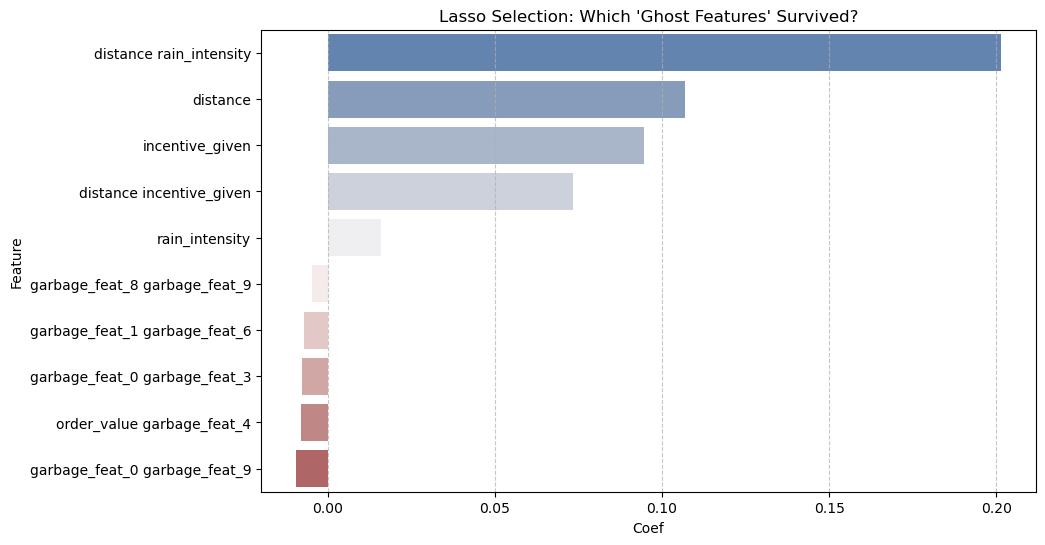

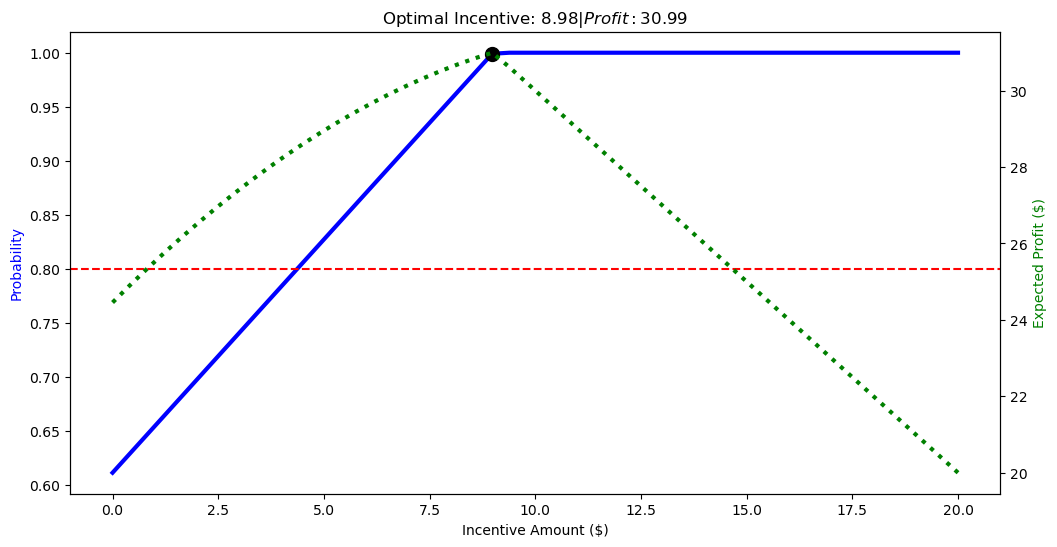

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# ==========================================
# 1. GENERATE "RIGGED" SYNTHETIC DATA
# ==========================================
# We create a world where only Distance * Rain matters, 
# and expensive orders are "chaotic" (high noise).
def generate_hackathon_data(n=2000):
    np.random.seed(42)
    dist = np.random.uniform(1, 15, n)    # 1km to 15km
    rain = np.random.uniform(0, 10, n)    # 0 (dry) to 10 (storm)
    val = np.random.uniform(20, 400, n)   # $20 to $400 order
    incentive = np.random.uniform(2, 15, n)
    
    # The "Ghost Signal": Interaction between Rain and Distance
    # Plus a base cost for distance and incentive impact
    signal = (2.0 * dist) + (0.5 * dist * rain) + (3.0 * incentive)
    
    # Adding "Chaos" (Heteroscedasticity): Noise grows with Order Value
    noise = np.random.normal(0, val/40, n)
    
    y_prob_raw = signal + noise
    # Convert signal to a 0-1 probability for acceptance
    y_prob = 1 / (1 + np.exp(-(y_prob_raw - np.mean(y_prob_raw))/5))
    y_accepted = (np.random.rand(n) < y_prob).astype(int)
    
    df = pd.DataFrame({
        'distance': dist,
        'rain_intensity': rain,
        'order_value': val,
        'incentive_given': incentive,
        'accepted': y_accepted
    })
    
    # Add 10 "Noise" features that do absolutely nothing
    for i in range(10):
        df[f'garbage_feat_{i}'] = np.random.normal(0, 1, n)
        
    return df

df = generate_hackathon_data()
print("Dataset Created. Shape:", df.shape)

# ==========================================
# 2. THE ML PIPELINE (LASSO + GHOST FEATURES)
# ==========================================
X = df.drop('accepted', axis=1)
y = df['accepted']

# Step A: Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

# Step B: Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Step C: LassoCV to find the "Magic" features
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Identify selected features
coef_df = pd.DataFrame({'Feature': feature_names, 'Coef': lasso.coef_})
magic_features = coef_df[coef_df['Coef'] != 0].sort_values(by='Coef', ascending=False)

# ==========================================
# 3. VISUALIZATION 1: THE COEFFICIENT PLOT
# ==========================================
plt.figure(figsize=(10, 6))
top_coefs = pd.concat([magic_features.head(5), magic_features.tail(5)])
sns.barplot(data=top_coefs, x='Coef', y='Feature', palette='vlag')
plt.title("Lasso Selection: Which 'Ghost Features' Survived?")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ==========================================
# 4. THE OPTIMIZER (FINDING THE SWEET SPOT)
# ==========================================
def optimize_order(sample_order, model, poly_transformer, scaler_obj):
    incentives = np.linspace(0, 20, 50)
    results = []
    
    for inc in incentives:
        temp_order = sample_order.copy()
        temp_order['incentive_given'] = inc
        
        # Transform for model
        order_poly = poly_transformer.transform(temp_order)
        order_scaled = scaler_obj.transform(order_poly)
        
        # Predict Probability
        # Note: LassoCV.predict returns a continuous value; we treat as probability proxy here
        prob = np.clip(model.predict(order_scaled)[0], 0, 1)
        
        # Expected Profit = (Revenue - Incentive) * Prob
        revenue = sample_order['order_value'].values[0] * 0.2 # 20% commission
        expected_profit = (revenue - inc) * prob
        
        results.append({'incentive': inc, 'prob': prob, 'profit': expected_profit})
    
    return pd.DataFrame(results)

# Pick a "Rainy & Long Distance" order to test
test_order = pd.DataFrame([{
    'distance': 12.0, 
    'rain_intensity': 8.0, 
    'order_value': 200.0, 
    'incentive_given': 0 # placeholder
}])
for i in range(10): test_order[f'garbage_feat_{i}'] = 0

opt_df = optimize_order(test_order, lasso, poly, scaler)

# ==========================================
# 5. VISUALIZATION 2: THE OPTIMIZATION CURVE
# ==========================================
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Acceptance Probability
ax1.plot(opt_df['incentive'], opt_df['prob'], color='blue', label='Acceptance Prob', linewidth=3)
ax1.set_xlabel('Incentive Amount ($)')
ax1.set_ylabel('Probability', color='blue')
ax1.axhline(0.8, color='red', linestyle='--', label='80% Threshold')

# Plot Expected Profit
ax2 = ax1.twinx()
ax2.plot(opt_df['incentive'], opt_df['profit'], color='green', label='Exp. Profit', linewidth=3, linestyle=':')
ax2.set_ylabel('Expected Profit ($)', color='green')

# Find the peak profit that meets threshold
valid_options = opt_df[opt_df['prob'] >= 0.8]
if not valid_options.empty:
    best = valid_options.loc[valid_options['profit'].idxmax()]
    plt.title(f"Optimal Incentive: ${best['incentive']:.2f} | Profit: ${best['profit']:.2f}")
    ax1.scatter(best['incentive'], best['prob'], color='black', s=100, zorder=5)

plt.show()